In [1]:
import pandas as pd
import numpy as np
import json
from pandas import json_normalize
# from google.colab import files
import pyarrow.parquet as pq
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime as dt
from datetime import timedelta
from operator import attrgetter



import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("supermarket.csv")
df.head()

,SHOP_WEEK,SHOP_DATE,SHOP_WEEKDAY,SHOP_HOUR,QUANTITY,SPEND,PROD_CODE,PROD_CODE_10,PROD_CODE_20,PROD_CODE_30,...,CUST_PRICE_SENSITIVITY,CUST_LIFESTAGE,BASKET_ID,BASKET_SIZE,BASKET_PRICE_SENSITIVITY,BASKET_TYPE,BASKET_DOMINANT_MISSION,STORE_CODE,STORE_FORMAT,STORE_REGION
0,200734,20071019,6,8,1,9.50,PRD0901335,CL00058,DEP00016,G00006,...,XX,OT,994108000679877,M,MM,Small Shop,Fresh,STORE00001,LS,E02
1,200805,20080328,6,21,1,1.49,PRD0901120,CL00162,DEP00055,G00016,...,XX,NaN,994110300629787,S,MM,Small Shop,Fresh,STORE00001,LS,E02
2,200716,20070612,3,9,1,0.86,PRD0900963,CL00248,DEP00089,G00030,...,NaN,NaN,994106200026009,S,MM,Small Shop,Grocery,STORE00001,LS,E02
3,200815,20080604,4,10,3,0.90,PRD0901055,CL00248,DEP00089,G00030,...,NaN,NaN,994111300076346,L,MM,Top Up,Grocery,STORE00001,LS,E02
4,200626,20060824,5,16,1,1.77,PRD0901877,CL00169,DEP00056,G00017,...,NaN,NaN,994102000065854,L,LA,Top Up,Fresh,STORE00001,LS,E02


# Basic Analytics

In [3]:
# df['SHOP_DATE'] = pd.to_datetime(df['SHOP_DATE'], format='%Y%m%d')
# create new df which nan valuues in CUST_CODE
df_non_member = df[df['CUST_CODE'].isna()]
df_member = df[df['CUST_CODE'].notna()]

In [4]:
# create new df which nan valuues in CUST_CODE
df_non_member = df[df['CUST_CODE'].isna()]
df_member = df[df['CUST_CODE'].notna()]

sum_basket_id = df_member["BASKET_ID"].nunique() + df_non_member["BASKET_ID"].nunique()
print(f"Unique basket id:",sum_basket_id)

sum_NMB_BASKET_ID = df_non_member["BASKET_ID"].nunique()
print(f"Sum non-member basket id:",sum_NMB_BASKET_ID)
print(f"Non-member basket id percentage:",sum_NMB_BASKET_ID/sum_basket_id*100,"%")

sum_MB_BASKET_ID = df_member["BASKET_ID"].nunique()
print(f"Sum member basket id:",sum_MB_BASKET_ID)
print(f"Member basket id percentage:",sum_MB_BASKET_ID/sum_basket_id*100,"%")

Unique basket id: 77234
Sum non-member basket id: 12075
Non-member basket id percentage: 15.634306134603932 %
Sum member basket id: 65159
Member basket id percentage: 84.36569386539607 %


In [5]:
# visualize the number of member and non-member
fig = px.pie(df, values=[sum_MB_BASKET_ID, sum_NMB_BASKET_ID], names=['Member', 'Non-member'], title='Number of Member and Non-member')
fig.show()

# Member

### Customer Single View (for Customer Segmentation)

In [6]:
df = df_member.copy()

##### Total Spend by Customer Code #####
features=df.groupby('CUST_CODE')['SPEND'].sum().reset_index()

#### Purchase Frequency #####
features['frequency'] = list(df.groupby('CUST_CODE')['BASKET_ID'].nunique())
features['startdate'] = list(df.groupby('CUST_CODE')['SHOP_DATE'].min())
features['startdate'] = features['startdate'].astype(str).apply(lambda x: datetime.strptime(x, "%Y%m%d").date())
features['lastdate'] = list(df.groupby('CUST_CODE')['SHOP_DATE'].max())
features['lastdate'] = features['lastdate'].astype(str).apply(lambda x: datetime.strptime(x, "%Y%m%d").date())

#### Ensure 'startdate' and 'lastdate' are of datetime type ####
features['startdate'] = pd.to_datetime(features['startdate'])
features['lastdate'] = pd.to_datetime(features['lastdate'])

#### Calculate 'total_time' column ####
features['total_time'] = (features['lastdate'] - features['startdate']).dt.days + 1

#### Calculate 'lifetime' column using timedelta ####
features['lifetime'] = (pd.to_datetime(df['SHOP_DATE'].max(), format="%Y%m%d") - features['startdate']).dt.days

#### Average Usage per User ####
arpu=features['SPEND'].sum()/features['CUST_CODE'].nunique()

#### CLTV ####
features['cltv']=features['lifetime']*arpu

#### AVERAGE SPEND ####
#features = features.merge(df.groupby('CUST_CODE')['BASKET_ID'].nunique().reset_index(), on='CUST_CODE', how='left')
features['avg_bskt_spend']=features['SPEND']/features['frequency']


features.head()

,CUST_CODE,SPEND,frequency,startdate,lastdate,total_time,lifetime,cltv,avg_bskt_spend
0,CUST0000000181,2.44,1,2007-01-06,2007-01-06,1,547,151020.342457,2.440000
1,CUST0000000689,328.57,16,2007-07-22,2008-06-23,338,350,96630.932102,20.535625
2,CUST0000000998,5.95,3,2006-05-04,2006-07-07,65,794,219214.171684,1.983333
3,CUST0000001163,39.74,4,2006-10-22,2008-06-22,610,623,172003.059142,9.935000
4,CUST0000001194,2493.83,103,2006-04-22,2008-06-20,791,806,222527.232213,24.211942


### Customer Segmentation

In [7]:
df_seg = features.copy()
df_seg.drop(['startdate', 'lastdate'], axis=1, inplace=True)
df_seg.set_index('CUST_CODE', inplace=True)

# power transform
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer() #default=’yeo-johnson’

df_seg_trans = pd.DataFrame(pt.fit_transform(df_seg))
df_seg_trans.columns = df_seg.columns
df_seg_trans.index = df_seg.index
df_seg_trans.head()

,SPEND,frequency,total_time,lifetime,cltv,avg_bskt_spend
CUST_CODE,,,,,,
CUST0000000181,-1.185334,-1.153823,-1.330595,-0.233676,-0.233346,-0.903753
CUST0000000689,1.058001,1.009318,0.485564,-1.109085,-1.108999,0.909081
CUST0000000998,-0.786407,-0.191905,-0.343147,1.113927,1.113723,-1.040488
CUST0000001163,0.126687,0.053790,0.871476,0.153642,0.153916,0.227877
CUST0000001194,1.828153,1.688204,1.059241,1.185657,1.185401,1.069443


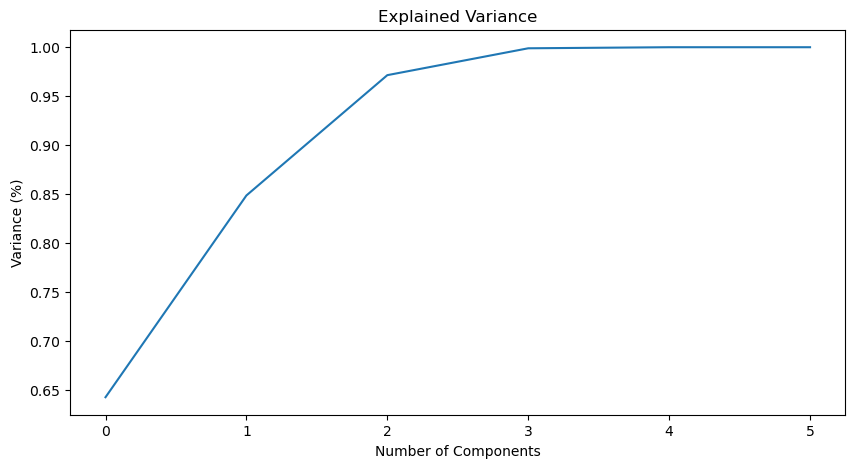

In [8]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df_seg_trans)
pca.explained_variance_ratio_

# Plotting the Cumulative Summation of the Explained Variance
plt.figure(figsize=(10,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

rule of thumb is to keep at least 70 to 80 percent of the explained variance.
So Let’s keep the first 2 components for our further analysis.

In [9]:
pca = PCA(n_components=2)
pca.fit(df_seg_trans)
print("explained_variance_ratio_:", pca.explained_variance_ratio_)

df_seg_PCA = pd.DataFrame(pca.transform(df_seg_trans), columns=(["PC1","PC2"]))
df_seg_PCA.describe().T

explained_variance_ratio_: [0.64272645 0.20595788]


,count,mean,std,min,25%,50%,75%,max
PC1,3439.0,8.264527e-18,1.964047,-3.781490,-1.677097,0.031299,1.614765,4.021061
PC2,3439.0,-2.660145e-17,1.111803,-3.160061,-0.714009,-0.005062,0.680127,3.527272


Elbow Method to determine the number of clusters to be formed:


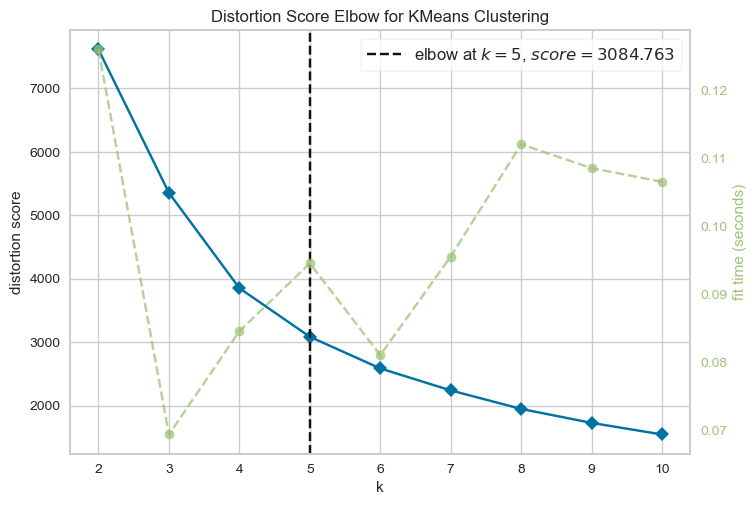

In [10]:
# K-Means Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer

# choose k by elbow method
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(random_state=42), k=10, scoere='calinski_harabasz')
Elbow_M.fit(df_seg_PCA)
Elbow_M.show();

In [11]:
# Initialize and fit the K-means model
kmeans = KMeans(n_clusters=5, random_state=42)

# Fit model and predict clusters
cluster = kmeans.fit_predict(df_seg_PCA)

# create a new column in the scaled dataframe with the cluster labels
df_seg_PCA["Clusters"] = cluster
df_seg_PCA

,PC1,PC2,Clusters
0,2.064250,-0.913698,2
1,-0.479188,2.121377,3
2,-0.042029,-2.028135,2
3,-0.646282,0.049627,4
4,-3.299128,0.424403,0
...,...,...,...
3434,-1.525468,-1.082895,4
3435,1.969752,0.055092,1
3436,-2.608580,-0.068233,0
3437,-1.614115,1.194494,0


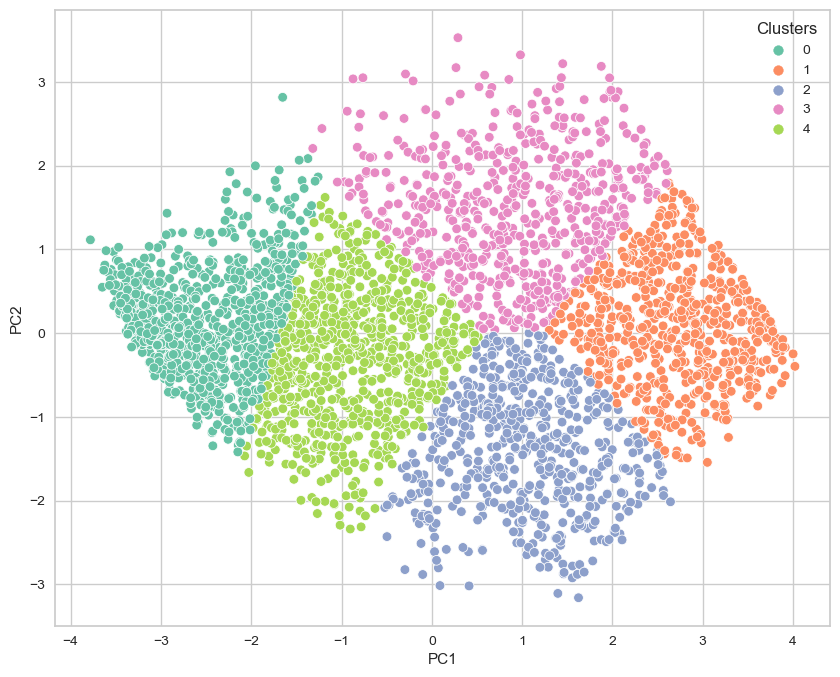

In [12]:
plt.figure(figsize=(10,8))
sns.scatterplot(x="PC1", y="PC2", hue="Clusters", data=df_seg_PCA, palette="Set2", legend='full')
plt.show()

,SPEND,frequency,total_time,lifetime,cltv,avg_bskt_spend
Clusters,,,,,,
0,975.970184,62.524741,730.752589,762.556962,210533.114348,19.805838
1,3.891856,1.291200,24.916800,298.899200,82522.595145,3.294750
2,4.651124,1.885860,149.054514,657.042589,181401.822424,3.252942
3,79.100833,4.938333,137.400000,351.966667,97173.905911,23.067042
4,64.283272,7.846966,480.899736,687.139842,189711.323963,11.946145


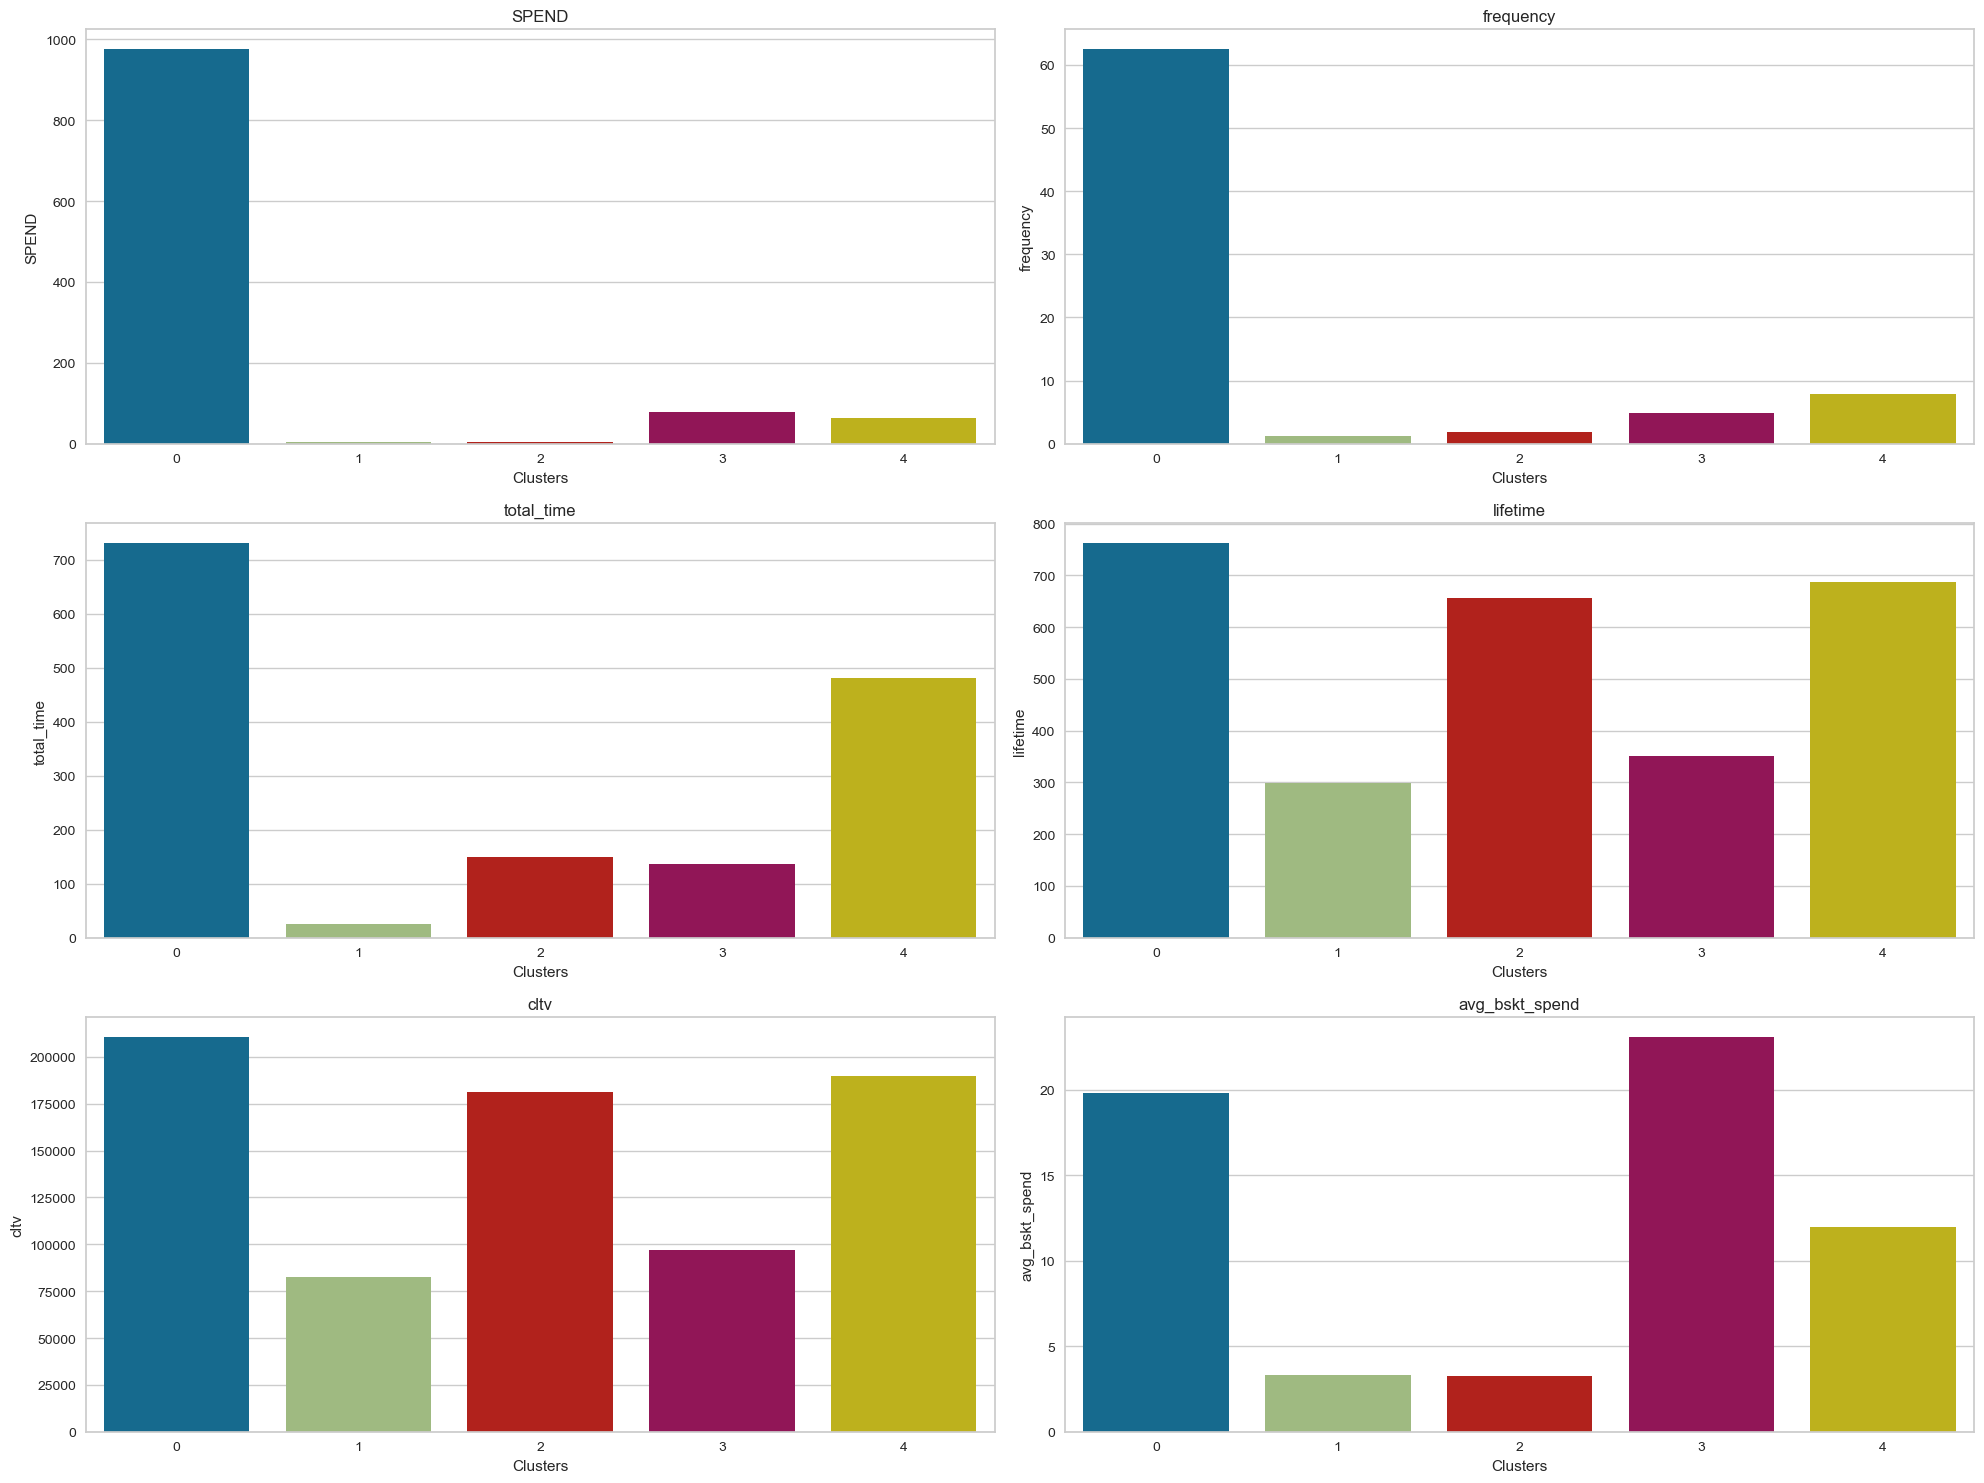

In [13]:
def bar_plot(df):
    # 2 columns
    num_cols = len(df.columns)
    num_rows = (num_cols + 1) // 2  # Calculate the number of rows based on the number of columns

    fig, ax = plt.subplots(num_rows, 2, figsize=(20, 5*num_rows))
    for i, col in enumerate(df.columns):
        sns.barplot(x=df.index, y=df[col], ax=ax[i//2, i%2])
        ax[i//2, i%2].set_title(col)

    # Remove any unused subplots
    if num_cols < num_rows * 2:
        for j in range(num_cols % 2, 2):
            fig.delaxes(ax[num_rows-1, j])
    plt.tight_layout()
    plt.show()

df_seg_final = df_seg.copy()
df_seg_final["Clusters"] = df_seg_PCA["Clusters"].values

df_seg_analysis = df_seg_final.groupby(["Clusters"]).mean()
display(df_seg_analysis)
bar_plot(df_seg_analysis)

# Cohort Analysis

In [14]:
df_cohort = df_member.copy()
df_cohort['SHOP_DATE'] = pd.to_datetime(df_cohort['SHOP_DATE'], format='%Y%m%d')
df_cohort['SHOP_MONTH'] = df_cohort['SHOP_DATE'].dt.to_period('m')

df_cohort['cohort'] = df_cohort.groupby('CUST_CODE')['SHOP_MONTH'].transform('min')

df_cohort = df_cohort.groupby(['cohort', 'SHOP_MONTH']).agg(n_customers=('CUST_CODE', 'nunique')).reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.SHOP_MONTH - df_cohort.cohort).apply(attrgetter('n'))

cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
retention_matrix.head()

period_number,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
cohort,,,,,,,,,,,,,,,,,,,,,
2006-04,1.0,0.652830,0.669811,0.698113,0.675472,0.684906,0.667925,0.637736,0.667925,0.635849,...,0.567925,0.558491,0.567925,0.549057,0.543396,0.550943,0.647170,0.692453,0.675472,0.343396
2006-05,1.0,0.322368,0.381579,0.371711,0.411184,0.384868,0.365132,0.371711,0.381579,0.332237,...,0.312500,0.319079,0.302632,0.279605,0.305921,0.342105,0.404605,0.384868,0.151316,NaN
2006-06,1.0,0.326531,0.367347,0.362245,0.265306,0.311224,0.367347,0.270408,0.234694,0.301020,...,0.311224,0.209184,0.234694,0.224490,0.295918,0.321429,0.326531,0.112245,NaN,NaN
2006-07,1.0,0.309735,0.305310,0.305310,0.269912,0.230088,0.247788,0.234513,0.212389,0.243363,...,0.203540,0.194690,0.238938,0.261062,0.252212,0.283186,0.101770,NaN,NaN,NaN
2006-08,1.0,0.230769,0.226244,0.185520,0.248869,0.180995,0.203620,0.230769,0.203620,0.162896,...,0.122172,0.122172,0.212670,0.194570,0.239819,0.058824,NaN,NaN,NaN,NaN


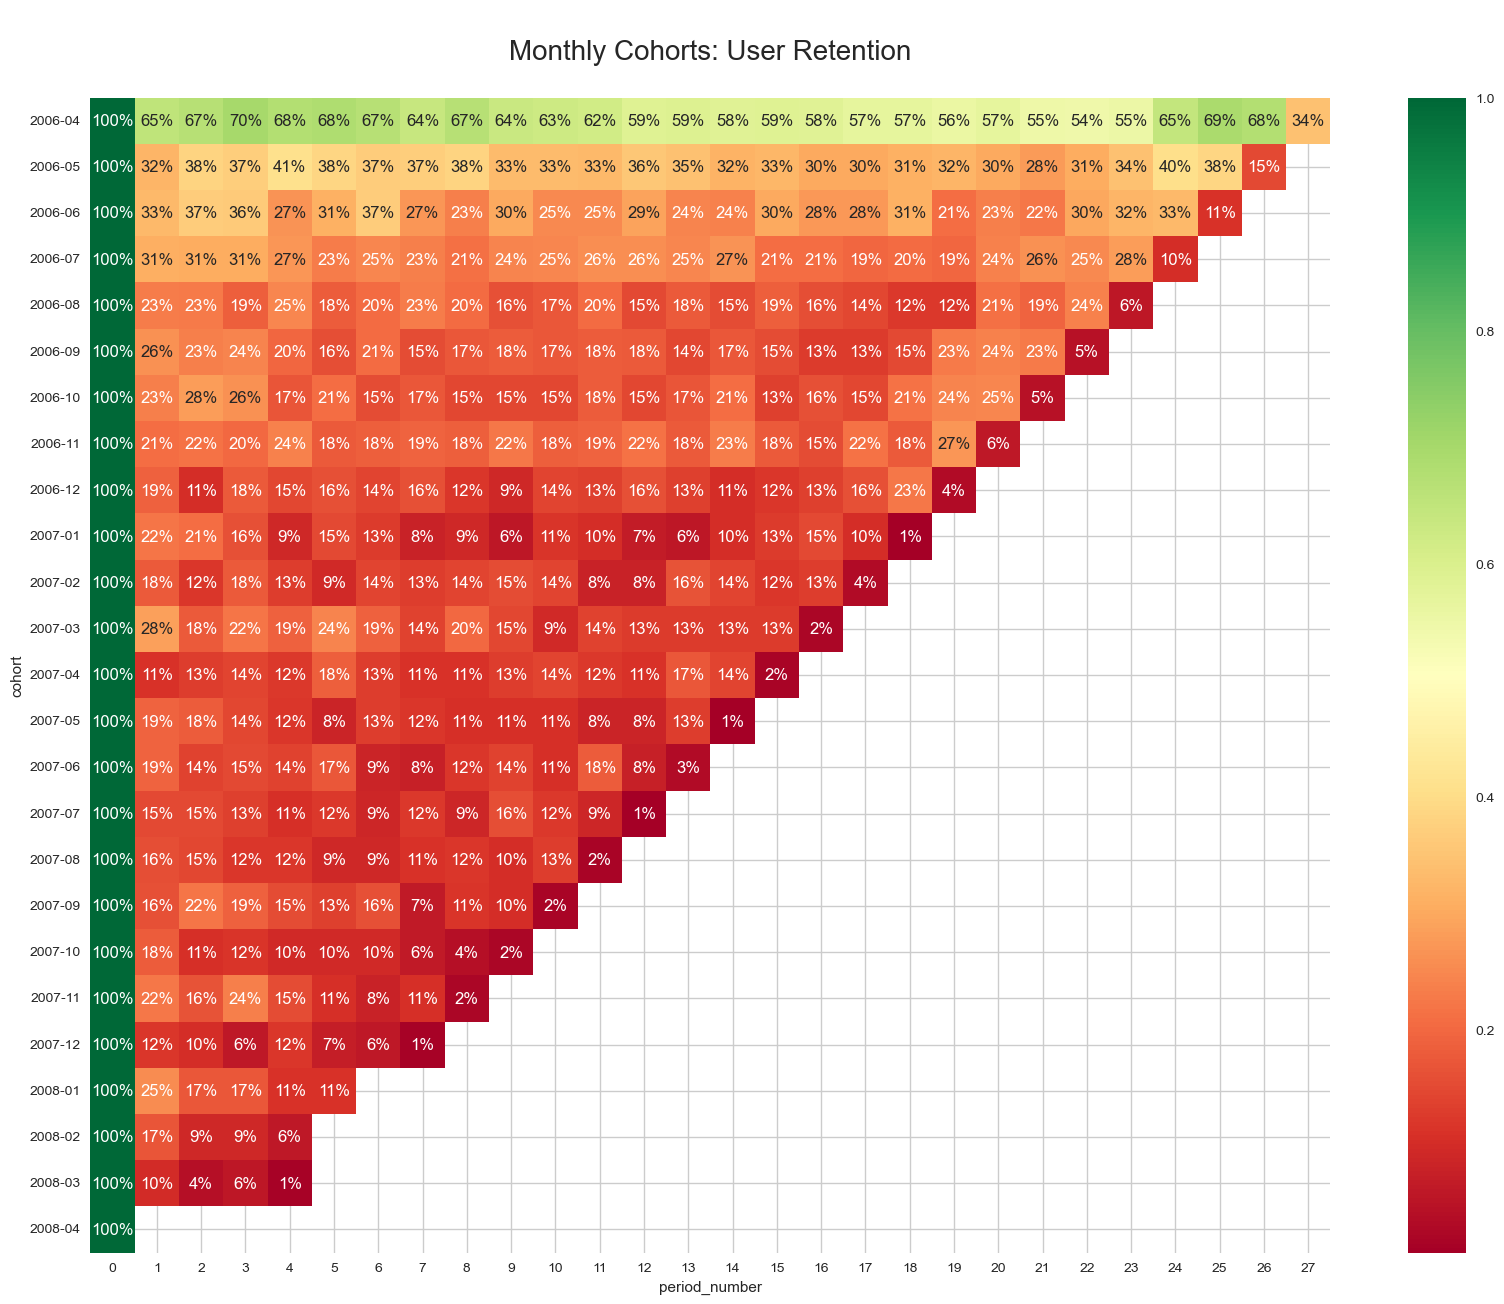

In [15]:
# Plot the retention matrix
plt.figure(figsize = (20, 15))
sns.heatmap(data = retention_matrix,
            annot = True,
            fmt = '.0%',
            cmap = 'RdYlGn')
# set the title of the figure
plt.title('\nMonthly Cohorts: User Retention\n', fontsize = 20)
plt.show()

# Customer Movement 

In [16]:
df_churn = df_member.copy()
df_churn['SHOP_DATE'] = pd.to_datetime(df_churn['SHOP_DATE'], format='%Y%m%d')
df_churn['SHOP_MONTH'] = df_churn['SHOP_DATE'].dt.to_period('m')

df_churn = df_churn[['CUST_CODE', 'SHOP_MONTH']].drop_duplicates().sort_values(by='SHOP_MONTH').reset_index(drop=True)
df_churn['start_month'] = df_churn.groupby('CUST_CODE')['SHOP_MONTH'].transform('min')
df_churn['period_number'] = (df_churn['SHOP_MONTH'] - df_churn['start_month']).apply(attrgetter('n')).astype(int)
df_churn.head()

,CUST_CODE,SHOP_MONTH,start_month,period_number
0,CUST0000890382,2006-04,2006-04,0
1,CUST0000410727,2006-04,2006-04,0
2,CUST0000688682,2006-04,2006-04,0
3,CUST0000906450,2006-04,2006-04,0
4,CUST0000970853,2006-04,2006-04,0


In [17]:
df_churn['labels'] = df_churn.apply(lambda row: 'new' if row['SHOP_MONTH'] == row['start_month'] else '', axis=1)
maxmonth = df_churn['SHOP_MONTH'].max()

for cust_code in df_churn['CUST_CODE'].unique() :
    period = df_churn.loc[df_churn['CUST_CODE'] == cust_code, :]['period_number']
    n = 0
    
    for p in period:
        if n+1==p : 
            df_churn.loc[(df_churn['CUST_CODE'] == cust_code) & (df_churn['period_number'] == p), ['labels']] = df_churn.loc[(df_churn['CUST_CODE'] == cust_code) & (df_churn['period_number'] == p), ['labels']].replace('','repeat')
            n+=1

        elif n+1 < p :
            last_order = df_churn.loc[(df_churn['CUST_CODE'] == cust_code) & (df_churn['period_number'] == n)]
            new_row = pd.DataFrame({'CUST_CODE': cust_code, 'labels': 'churn', 'period_number':n+1, 'SHOP_MONTH':last_order['SHOP_MONTH'].values[0]+1}, index=[0])
            df_churn = pd.concat([new_row,df_churn.loc[:]])

            df_churn.loc[(df_churn['CUST_CODE'] == cust_code) & (df_churn['period_number'] == p), ['labels']] = df_churn.loc[(df_churn['CUST_CODE'] == cust_code) & (df_churn['period_number'] == p), ['labels']].replace('','reactivated')
            n=p
            
    user_maxmonth = df_churn[df_churn['CUST_CODE'] == cust_code]['SHOP_MONTH'].max()
    if user_maxmonth != maxmonth:
        new_row = pd.DataFrame({'CUST_CODE': cust_code, 'labels': 'churn', 'period_number':p+1, 'SHOP_MONTH':user_maxmonth+1}, index=[0])
        df_churn = pd.concat([new_row,df_churn.loc[:]])

df_churn_plot = pd.pivot_table(data=df_churn, values='CUST_CODE', index='SHOP_MONTH', columns='labels', aggfunc='count', fill_value=0).reset_index()
df_churn_plot['churn'] = -df_churn_plot['churn']
df_churn_plot['SHOP_MONTH'] = df_churn_plot['SHOP_MONTH'].astype('str')

df_churn_plot.head()

labels,SHOP_MONTH,churn,new,reactivated,repeat
0,2006-04,0,530,0,0
1,2006-05,-184,304,0,346
2,2006-06,-247,196,50,403
3,2006-07,-206,226,107,443
4,2006-08,-285,221,122,491


In [18]:
# churn plot
fig = px.bar(df_churn_plot, x='SHOP_MONTH', y=['new', 'repeat', 'reactivated', 'churn'], title='Customer Churn by Month')
fig.update_layout(barmode='relative', xaxis={'categoryorder':'category ascending'})

fig.update_traces(marker_color='#00CC96', selector=dict(name='new'))
fig.update_traces(marker_color='#636EFA', selector=dict(name='repeat'))
fig.update_traces(marker_color='#FECB52', selector=dict(name='reactivated'))
fig.update_traces(marker_color='#EF553B', selector=dict(name='churn'))

# update xaxis
fig.update_xaxes(title_text='Month')
fig.update_yaxes(title_text='Number of Customers')
fig.show()
